In [1]:
import pandas as pd
import numpy as np

# check installed version
import pycaret
pycaret.__version__
from pycaret.classification import *

# figure
import matplotlib.pyplot as plt


In [2]:
# loading sample dataset from pycaret dataset module
from pycaret.datasets import get_data
data = get_data('juice')

,Id,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [3]:
# RANDOMLY FILL NANs
#data = data.mask(np.random.random(data.shape) < .1)
#data = data[~data['Class variable'].isnull()]
#data.isnull().sum()

In [4]:
RANDOM_STATE = 42
EXPERIMENT_NAME = "nba_yoda"

In [6]:
# Pycaret base configurations
pycaret_config = {
    
     'train_size' : 0.7
     #, 'test_data' : x_test
     #, 'ordinal_features' : {}
     #, 'numeric_features' : []
     #, 'categorical_features' : []
     #, 'date_features' : []
     #, 'text_features' : []
     #, 'bin_numeric_features' : []
     #, 'ignore_features' : []
     #, 'keep_features' : []
     , 'preprocess' : True
     , 'imputation_type' : 'simple'
     , 'categorical_imputation' : 'mode'
     , 'data_split_shuffle' : True
     , 'session_id' : RANDOM_STATE
     #, 'log_experiment' : 'mlflow'
     #, 'experiment_name' : EXPERIMENT_NAME
     #, 'experiment_custom_tags' : {}
     , 'log_plots' : True
     , 'log_data' : True
}

In [211]:
#pycaret_setup = setup(data, target = 'Class variable', **pycaret_config)

,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(689, 9)"
4,Transformed data shape,"(689, 9)"
5,Transformed train set shape,"(482, 9)"
6,Transformed test set shape,"(207, 9)"
7,Numeric features,8
8,Rows with missing values,57.9%
9,Preprocess,True


In [228]:
# init setup
#clf1 = setup(data, target = 'Class variable', session_id = 123)
#model = clf1.create_model('xgboost')

,Description,Value
0,Session id,123
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(689, 9)"
4,Transformed data shape,"(689, 9)"
5,Transformed train set shape,"(482, 9)"
6,Transformed test set shape,"(207, 9)"
7,Numeric features,8
8,Rows with missing values,57.9%
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7755,0.8897,0.5294,0.7500,0.6207,0.4679,0.4822
1,0.7347,0.8333,0.7222,0.6190,0.6667,0.4485,0.4522
2,0.6875,0.7590,0.6471,0.5500,0.5946,0.3431,0.3461
3,0.7292,0.8178,0.7059,0.6000,0.6486,0.4307,0.4344
4,0.6875,0.7913,0.5882,0.5556,0.5714,0.3258,0.3262
5,0.7708,0.8444,0.7647,0.6500,0.7027,0.5182,0.5228
6,0.7083,0.7666,0.5882,0.5882,0.5882,0.3624,0.3624
7,0.6250,0.6907,0.5882,0.4762,0.5263,0.2216,0.2250
8,0.7083,0.8520,0.4706,0.6154,0.5333,0.3267,0.3329


In [200]:
# Pycaret numeric configurations
pycaret_numeric = {
     'numeric_imputation' : 'mean'
}

# Pycaret imbalance configurations
pycaret_imbalance = {
                     'fix_imbalance' : True
                     , 'fix_imbalance_method' : 'SMOTE'
}

# Pycaret multi-collinear configurations
pycaret_multicol = {
                     'remove_multicollinearity' : True
                    , 'multicollinearity_threshold' : 0.5
}

# Pycaret outliers configurations
pycaret_outliers = {
                     'remove_outliers' : True
                    , 'outliers_method' : 'iforest'
                    , 'outliers_threshold' : 0.05
}

# Pycaret normalise configurations
pycaret_normalise = {
                     'normalize' : True
                    , 'normalize_method' : 'zscore'
}

# Pycaret transformation configurations
pycaret_transform = {
                     'transformation' : True
                    , 'transformation_method' :'yeo-johnson'
}


In [222]:
# numeric imputation
def analyze_num_input(data, target, filepath, pycaret_config, pycaret_numeric=None):
    
    if pycaret_numeric is None: # if there is no config, conduct analysis
        for change in ['drop', 'knn', 'mean', 'mode', 'median']:
            globals()[f'clf_{change}'] = setup(data, target = target
                                                   , **pycaret_config
                                                   , numeric_imputation = change)
            compare_preprocessed(globals()[f'clf_{change}'], f"Filling nulls by {change}", f"{filepath}_{change}")
            
    else: # if theres config, use defined configurations
        config = {**pycaret_config, **pycaret_numeric}
        pycaret_setup = setup(data, target = target, **config)
        compare_preprocessed(pycaret_setup, f"Filling nulls", filepath)


# imbalance data
def analyze_imbalance_fix(data, target, filepath, pycaret_config, pycaret_imbalance=None):
    
    if pycaret_imbalance is None: # if there is no config, conduct analysis
        col_cnt = pd.DataFrame(columns=['adjustments', 'before', 'after', 'difference'])

        for change in ['SMOTE', 'RandomOverSampler']:
            globals()[f'clf_{change}'] = setup(data, target = target
                                                   , **pycaret_config
                                                   , fix_imbalance = True
                                                   , fix_imbalance_method = change)
            col_cnt = col_cnt.append({"adjustments": f"No. columns left - {change}"
                            , "before": len(globals()[f'clf_{change}'].get_config('X_train').columns)
                            , "after": len(globals()[f'clf_{change}'].get_config('X_transformed').columns)
                            , "difference": list(globals()[f'clf_{change}'].get_config('X_train').columns[~ globals()[f'clf_{change}'].get_config('X_train').columns.isin(globals()[f'clf_{change}'].get_config('X_transformed').columns)])}
                           , ignore_index=True)
        
        # Print for viewing
        #for change in ['SMOTE', 'RandomOverSampler']:
        #    print(f"No. columns left - {change} : {len(globals()[f'clf_{change}'].get_config('X_transformed').columns)}")
        #print(f"No. columns before : {len(globals()[f'clf_{change}'].get_config('X_train').columns)}")
    
        col_cnt.to_csv(filepath + f'imbalance_fix_{change}.csv')
    
    else: # if theres config, use defined configurations
        col_cnt = pd.DataFrame(columns=['adjustments', 'before', 'after', 'difference'])
        config = {**pycaret_config, **pycaret_imbalance}
        
        pycaret_setup = setup(data, target = target, **config)
        col_cnt = col_cnt.append({"adjustments": f"No. columns left - {change}"
                , "before": len(pycaret_setup.get_config('X_train').columns)
                , "after": len(pycaret_setup.get_config('X_transformed').columns)
                , "difference": list(pycaret_setup.get_config('X_train').columns[~ pycaret_setup.get_config('X_train').columns.isin(pycaret_setup.get_config('X_transformed').columns)])}
               , ignore_index=True)
        
        col_cnt.to_csv(filepath + 'imbalance_fix.csv')  

# remove_multicollinearity
def analyze_rm_multicol(data, target, filepath, pycaret_config, pycaret_multicol=None):
    
    if pycaret_multicol is None: # if there is no config, conduct analysis
        col_cnt = pd.DataFrame(columns=['adjustments', 'before', 'after', 'difference'])

        for change in [0.1, 0.5, 0.9]:
            globals()[f'clf_{change}'] = setup(data, target = target
                                                   , **pycaret_config
                                                   , remove_multicollinearity = True
                                                   , multicollinearity_threshold = change)
            col_cnt = col_cnt.append({"adjustments": f"No. columns left - {change}"
                            , "before": len(globals()[f'clf_{change}'].get_config('X_train').columns)
                            , "after": len(globals()[f'clf_{change}'].get_config('X_transformed').columns)
                            , "difference": list(globals()[f'clf_{change}'].get_config('X_train').columns[~ globals()[f'clf_{change}'].get_config('X_train').columns.isin(globals()[f'clf_{change}'].get_config('X_transformed').columns)])}
                           , ignore_index=True)
        
        # Print for viewing
        #for change in [0.1, 0.5, 0.9]:
            #print(f"No. columns left - {change} : {len(globals()[f'clf_{change}'].get_config('X_transformed').columns)}")
        #print(f"No. columns before : {len(globals()[f'clf_{change}'].get_config('X_train').columns)}")
    
        col_cnt.to_csv(filepath + f'multicollinear_fix_{change}.csv')
        
    else: # if theres config, use defined configurations
        col_cnt = pd.DataFrame(columns=['adjustments', 'before', 'after', 'difference'])
        config = {**pycaret_config, **pycaret_multicol}
        
        pycaret_setup = setup(data, target = target, **config)
        col_cnt = col_cnt.append({"adjustments": f"No. columns left - {change}"
                , "before": len(pycaret_setup.get_config('X_train').columns)
                , "after": len(pycaret_setup.get_config('X_transformed').columns)
                , "difference": list(pycaret_setup.get_config('X_train').columns[~ pycaret_setup.get_config('X_train').columns.isin(pycaret_setup.get_config('X_transformed').columns)])}
               , ignore_index=True)
        
        col_cnt.to_csv(filepath + f'multicollinear_fix.csv')

    
# remove_outliers
def analyze_rm_outliers(data, target, filepath, pycaret_config, pycaret_outliers=None):
    
    if pycaret_outliers is None: # if there is no config, conduct analysis
        for change in ['iforest', 'ee', 'lof']:
            for threshold in [0.001, 0.01, 0.05]:
                globals()[f'clf_{change}'] = setup(data, target = target
                                                       , **pycaret_config
                                                       , remove_outliers = True
                                                       , outliers_method = change
                                                       , outliers_threshold = threshold)
                compare_preprocessed(globals()[f'clf_{change}'], f"Removal of outliers ({threshold*100}%) by {change}", f"{filepath}_{int(threshold*100)}pct_{change}")
                
    else: # if theres config, use defined configurations
        config = {**pycaret_config, **pycaret_numeric}
        pycaret_setup = setup(data, target = target, **config)
        compare_preprocessed(pycaret_setup, f"Removing outliers", filepath)

# normalize data
def analyze_normalise(data, target, filepath, pycaret_config, pycaret_normalise=None):
    
    if pycaret_normalise is None: # if there is no config, conduct analysis
        for change in ['zscore', 'minmax', 'maxabs', 'robust']:
            globals()[f'clf_{change}'] = setup(data, target = target
                                                   , **pycaret_config
                                                   , normalize = True
                                                   , normalize_method = change)
            compare_preprocessed(globals()[f'clf_{change}'], f"Normalised by {change}", f"{filepath}_{change}")
            
    else: # if theres config, use defined configurations
        config = {**pycaret_config, **pycaret_normalise}
        pycaret_setup = setup(data, target = target, **config)
        compare_preprocessed(pycaret_setup, f"Normalised", filepath)
        

# transformation
def analyze_transformation(data, target, filepath, pycaret_config, pycaret_transform=None):
    
    if pycaret_transform is None: # if there is no config, conduct analysis
        for change in ['yeo-johnson', 'quantile']:
            globals()[f'clf_{change}'] = setup(data, target = target
                                                   , **pycaret_config
                                                   , transformation = True
                                                   , transformation_method = change)
            compare_preprocessed(globals()[f'clf_{change}'], f"Transformed by {change}", f"{filepath}_{change}")
            
    else: # if theres config, use defined configurations
        config = {**pycaret_config, **pycaret_transform}
        pycaret_setup = setup(data, target = target, **config)
        compare_preprocessed(pycaret_setup, f"Transformed", filepath)


In [223]:
# lets check the X_train_transformed to see effect of params passed
def compare_preprocessed(method
                         , pycaret_setup:str
                         , saveimg_filepath:str = None):
    """
    This function compares the data pre-processing methods applied to the TRAIN dataset by displaying
    a histogram plot of each features (before and after preprocessing).
    
    INPUTS
        method : the type of preprocessing done, this would be displayed as main title on the subplot diagram
        pycaret_setup: the pycaret function that initialises the training environment and creates the transformation pipeline.
                       Required to fetch the original and pre-processed TRAIN dataset.
        saveimg_filepath: the save histogram plot path. If none, the plot will be displayed.
        
    OUTPUTS
        histogram subplots of features in TRAIN dataset
    
    """
    
    # (1) Set dataset based on parameters
    data = np.array(pycaret_setup.get_config('X_train').transpose())
    transformed = np.array(pycaret_setup.get_config('X_train_transformed').transpose())
    features = list(pycaret_setup.get_config('X_train').columns)
    
    # (2) Determine the no. of rows based on number of features for subplots
    num_cols = 2
    num_rows = int(-(-(len(features)/num_cols) // 1)) # round up

    # (3) Plot the subplots for each feature
    f, ax = plt.subplots(num_rows, num_cols, figsize=(10,15))
    ax = ax.ravel()
    for idx in range(num_cols*num_rows):
        ax[idx].hist(data[idx], alpha=0.5, label = "original", color= 'gray')
        ax[idx].hist(transformed[idx], alpha=0.5, label = "transformed")
        ax[idx].set_ylabel('count')
        ax[idx].set_xlabel(features[idx])
        ax[idx].legend(loc='upper right')
    
    plt.suptitle(f"{method}")
    
    if saveimg_filepath = None:
        # Display plot
        plt.tight_layout()
    else:
        # Save plot
        plt.savefig(saveimg_filepath)

,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(689, 9)"
4,Transformed data shape,"(689, 9)"
5,Transformed train set shape,"(482, 9)"
6,Transformed test set shape,"(207, 9)"
7,Numeric features,8
8,Rows with missing values,57.9%
9,Preprocess,True


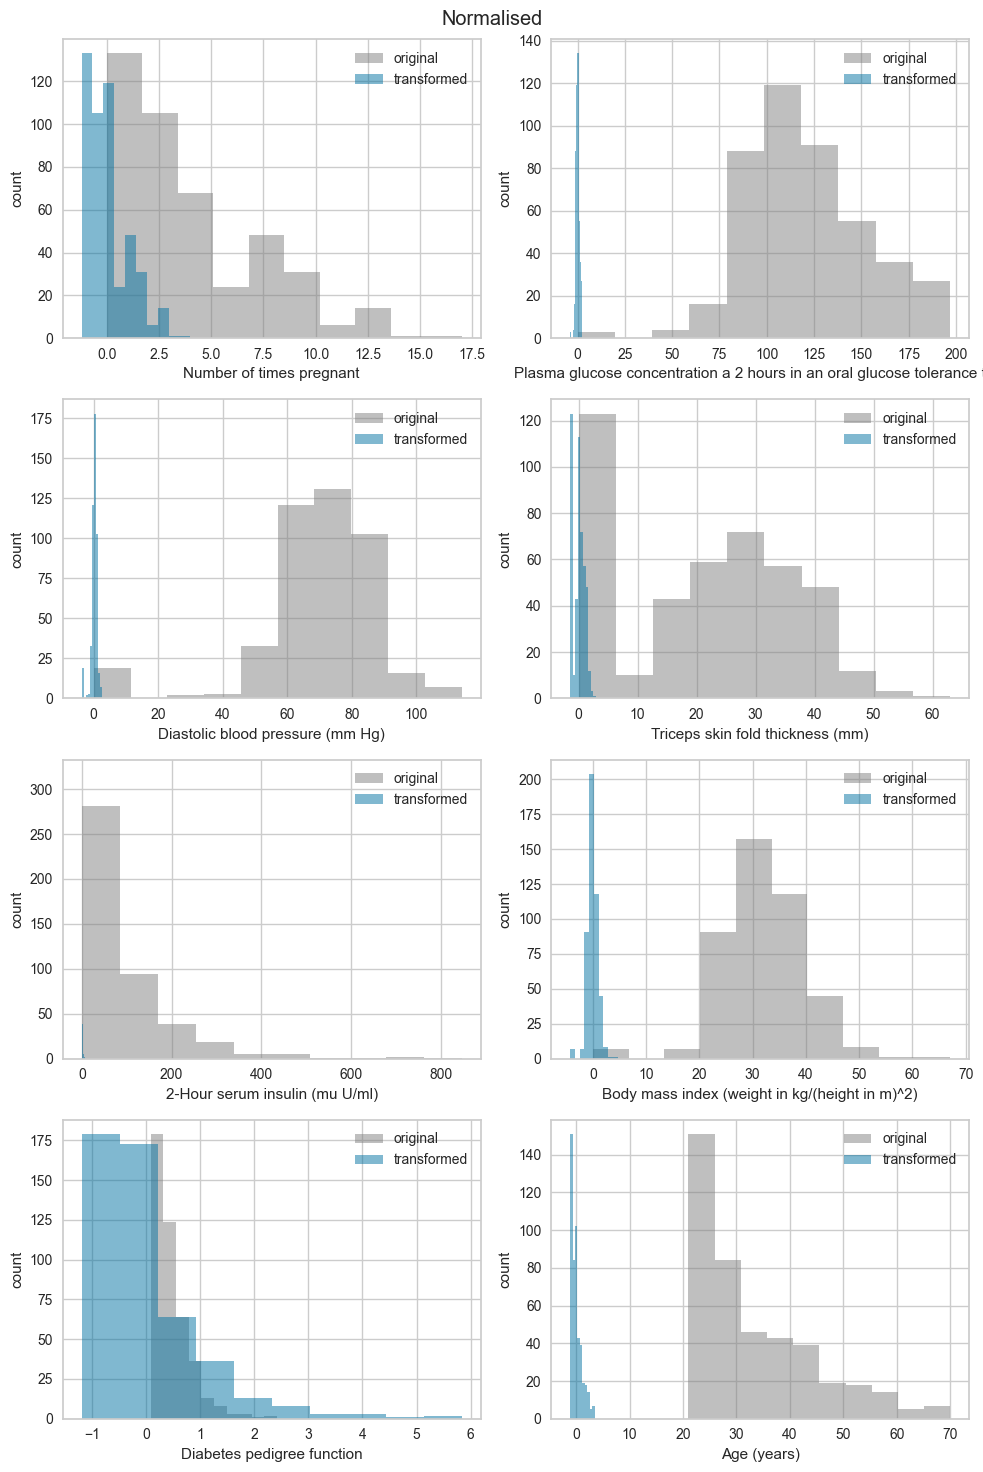

In [225]:
#target = 'Class variable'
#analyze_normalise(data, target, pycaret_config, pycaret_normalise)

,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(762, 9)"
5,Transformed train set shape,"(531, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(741, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(725, 9)"
5,Transformed train set shape,"(494, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(762, 9)"
5,Transformed train set shape,"(531, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(741, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(725, 9)"
5,Transformed train set shape,"(494, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(762, 9)"
5,Transformed train set shape,"(531, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(741, 9)"
5,Transformed train set shape,"(510, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(725, 9)"
5,Transformed train set shape,"(494, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


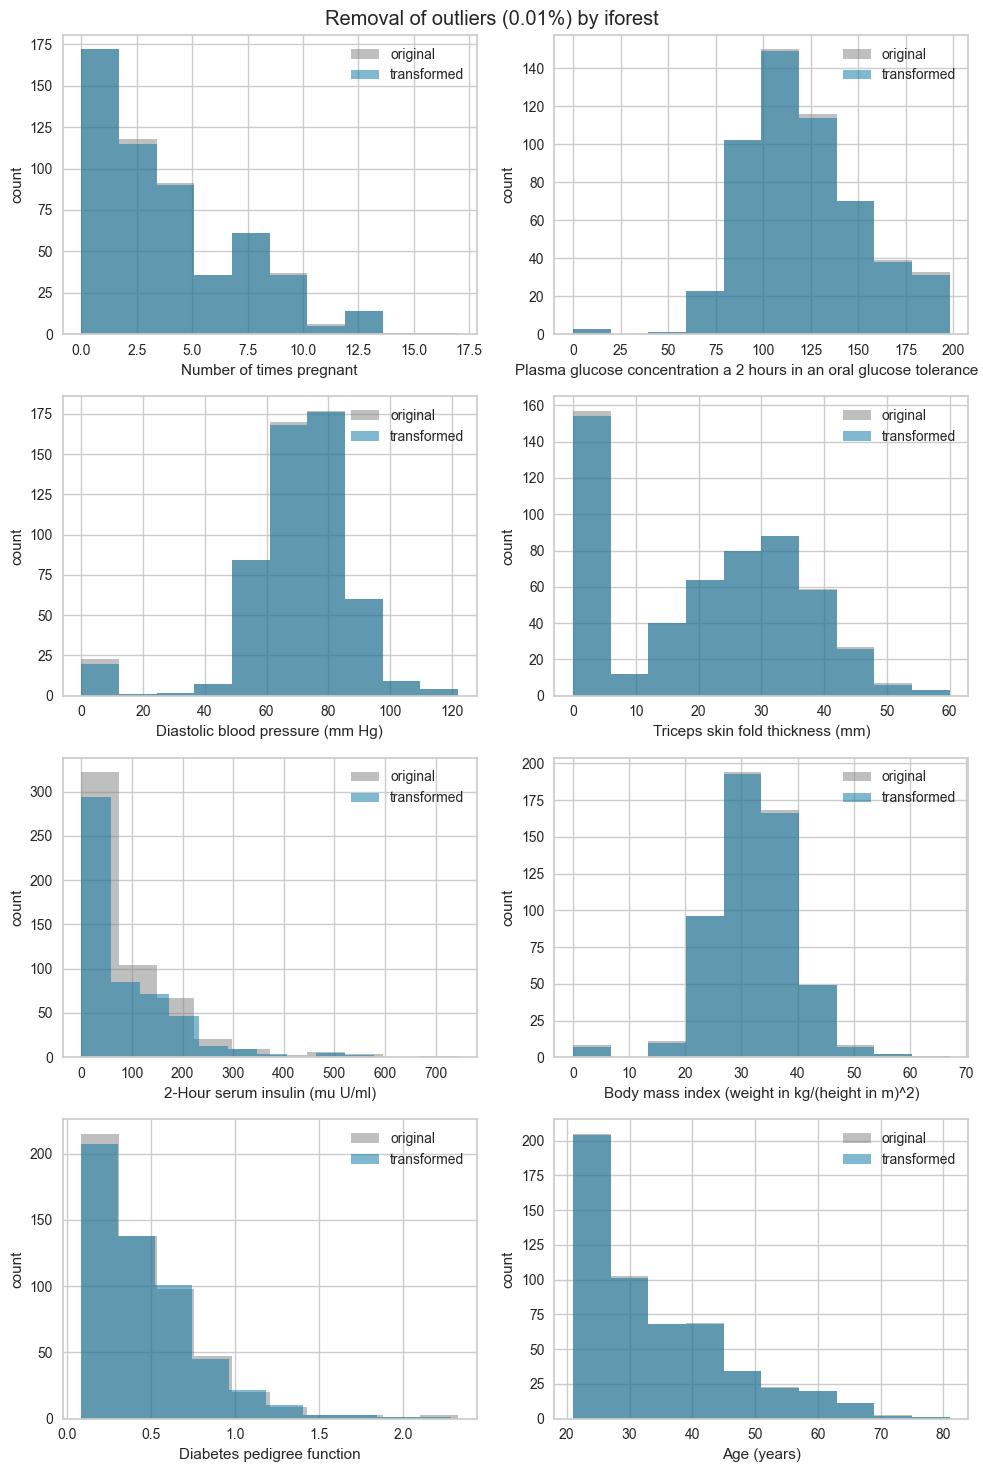

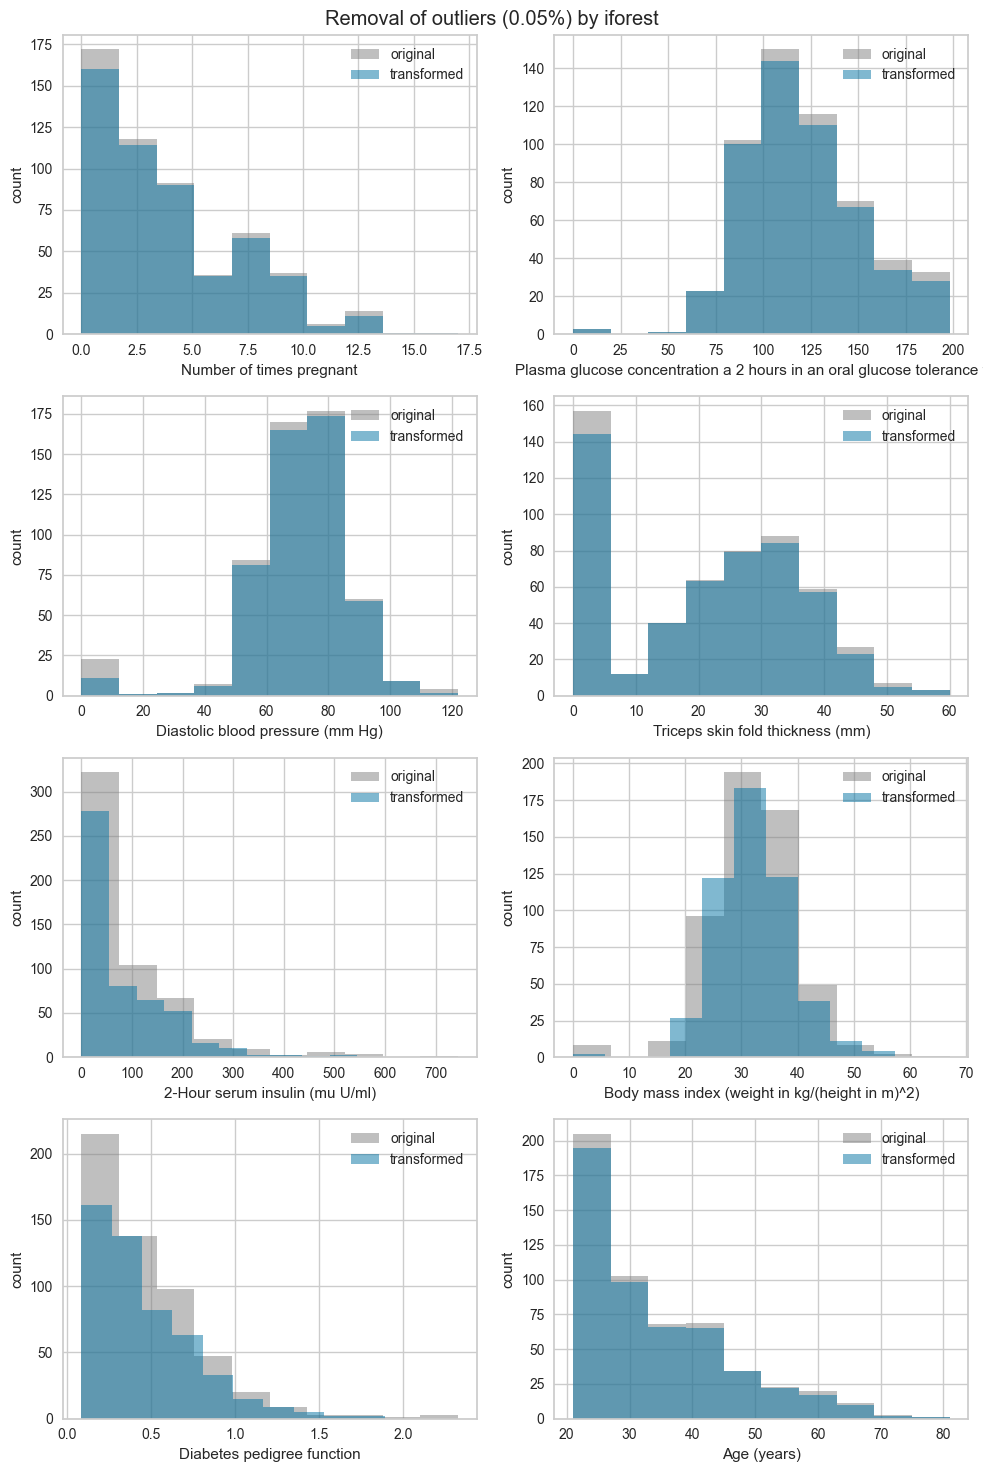

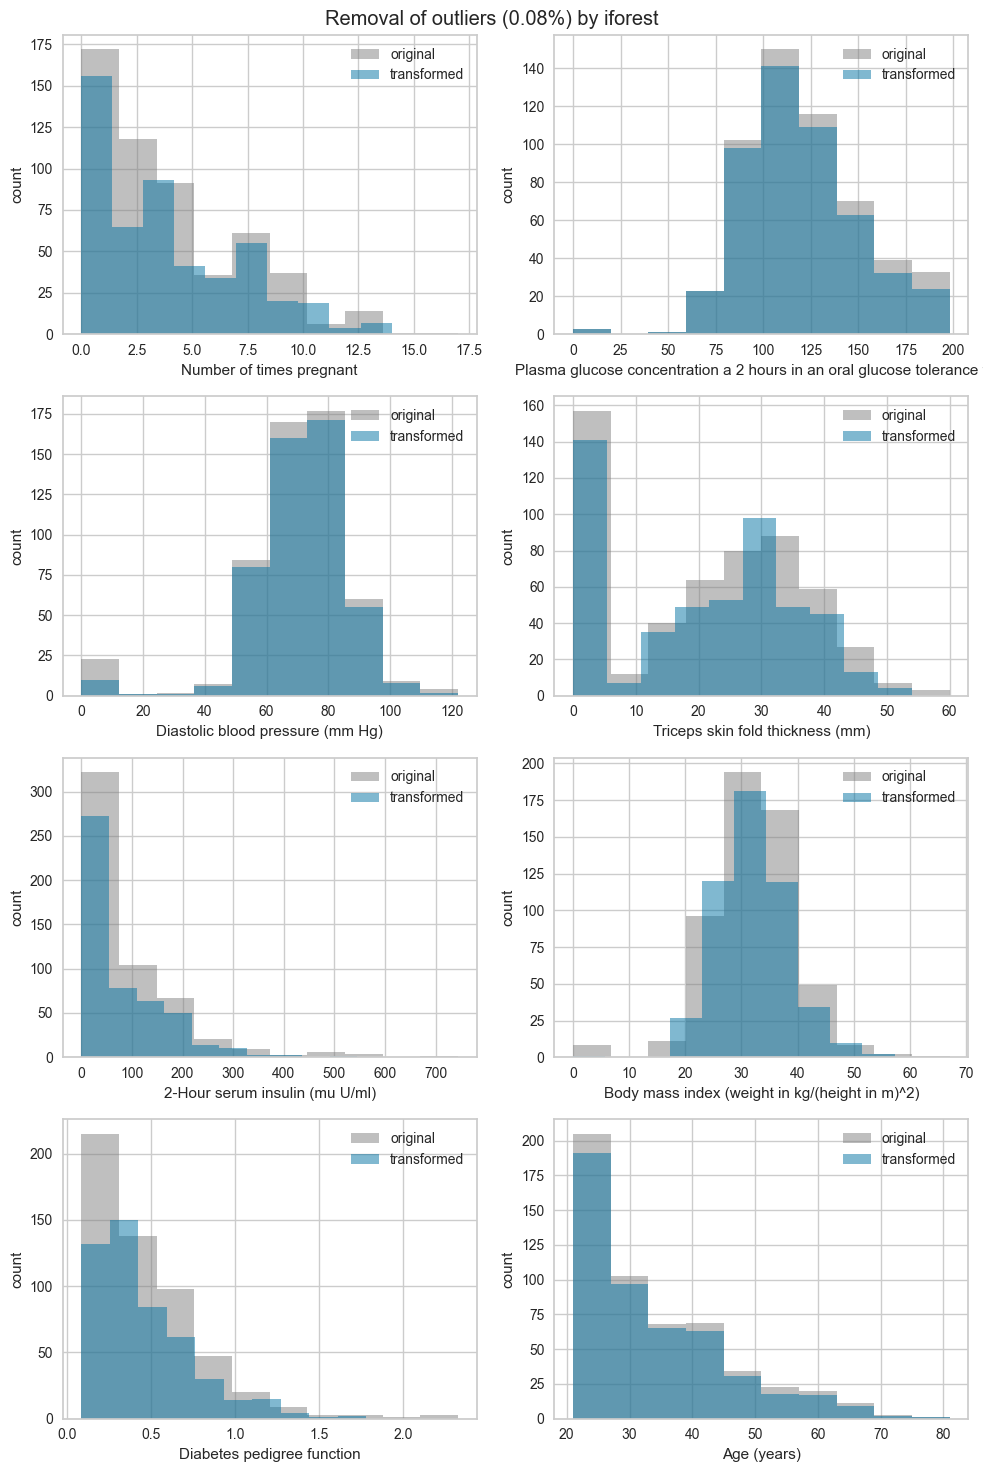

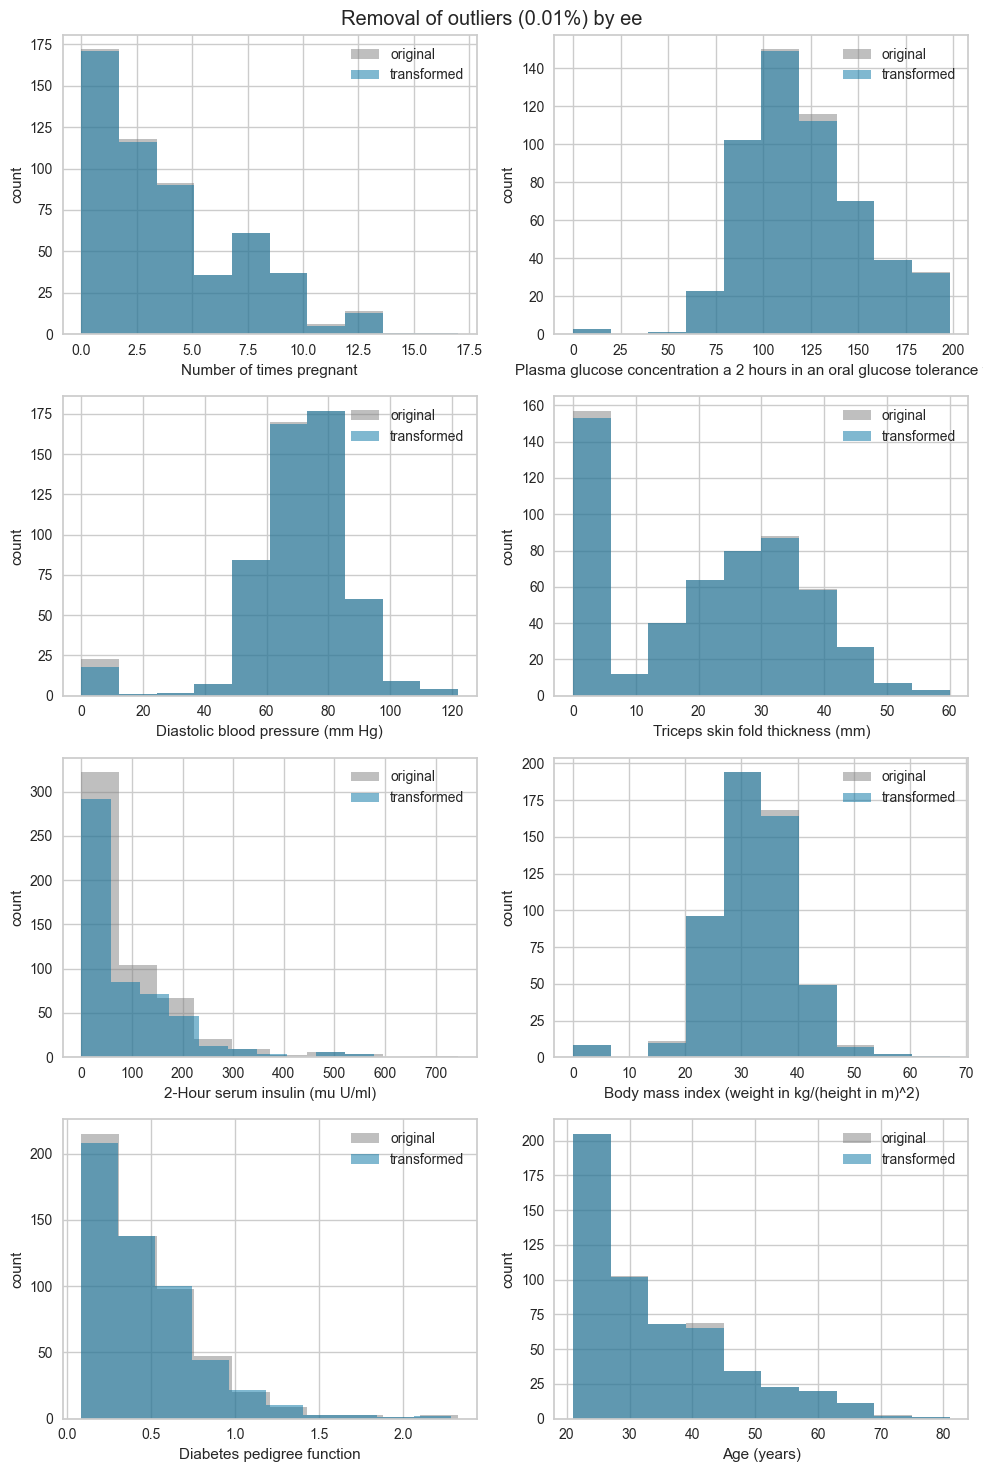

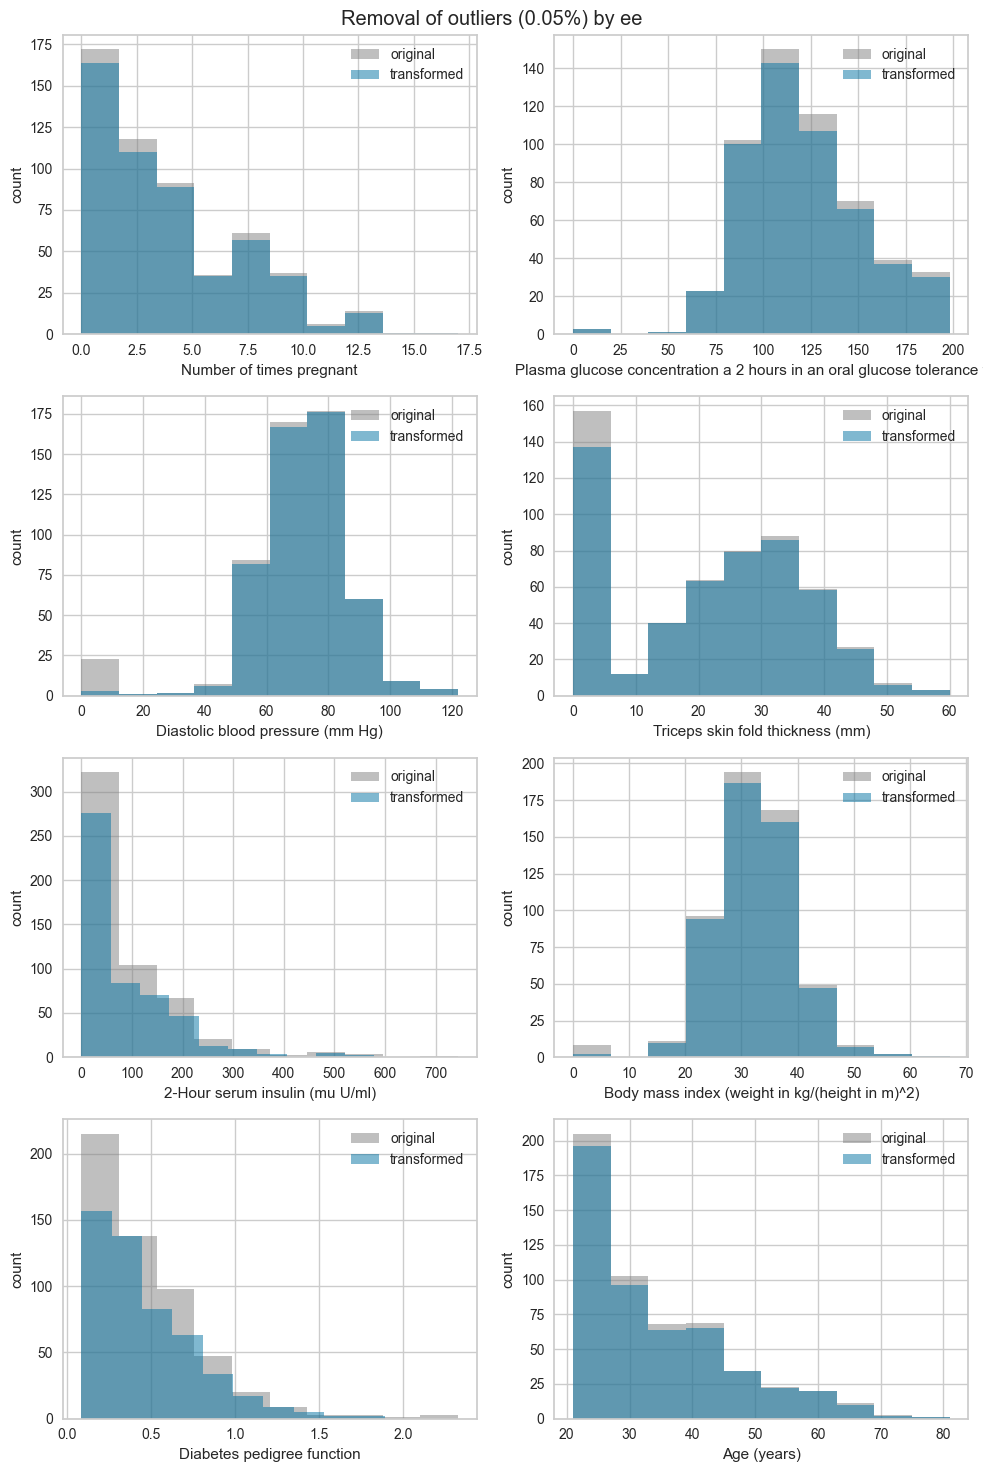

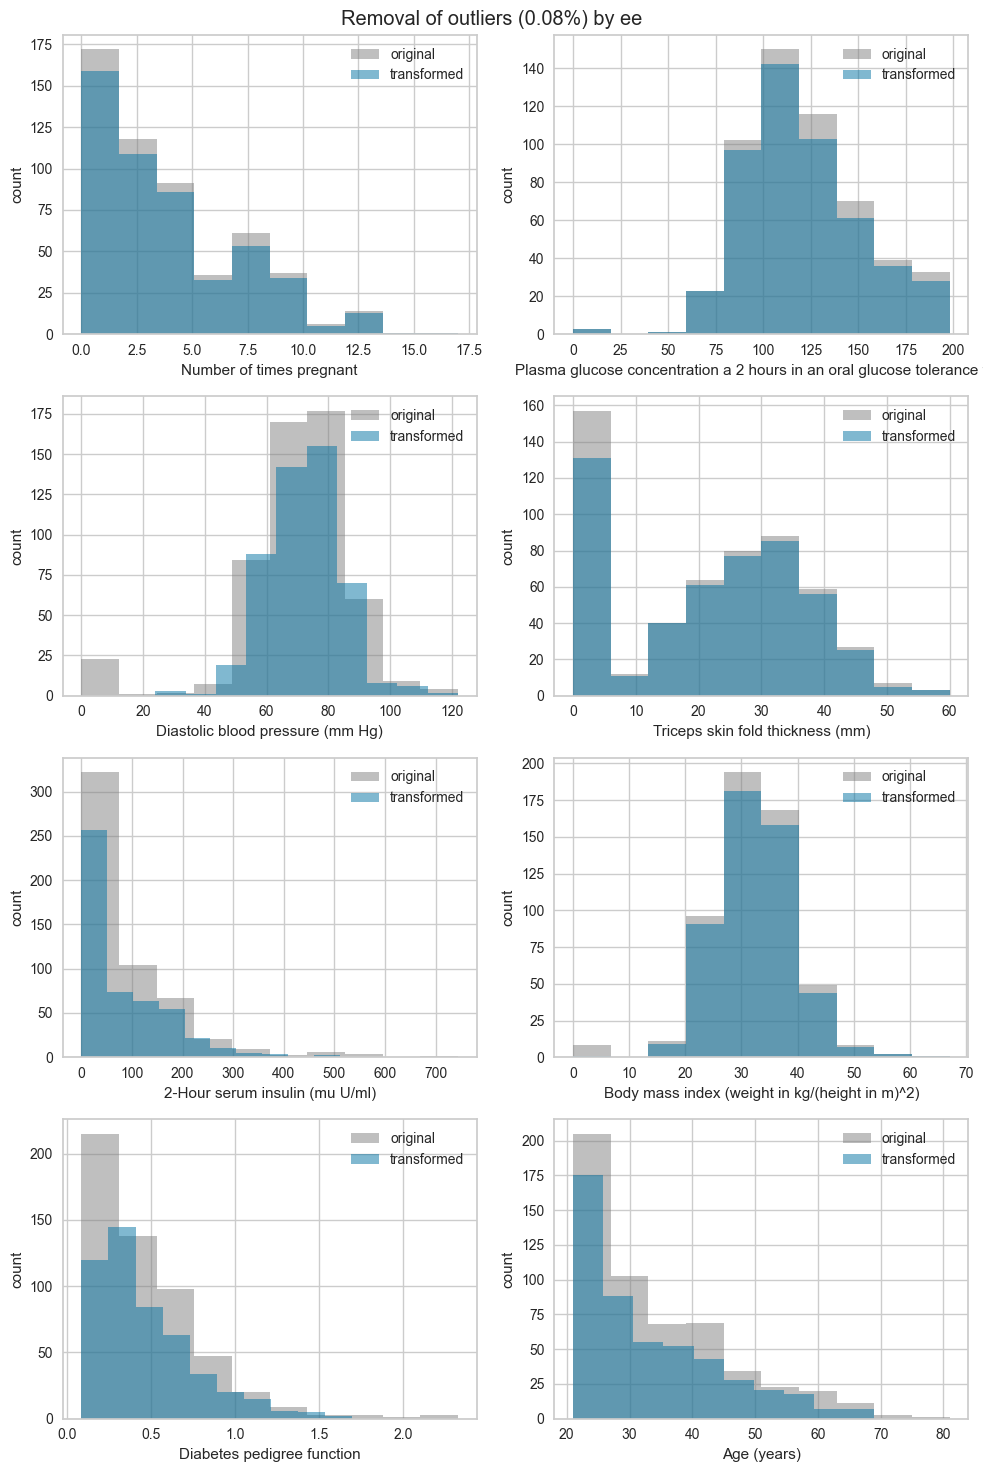

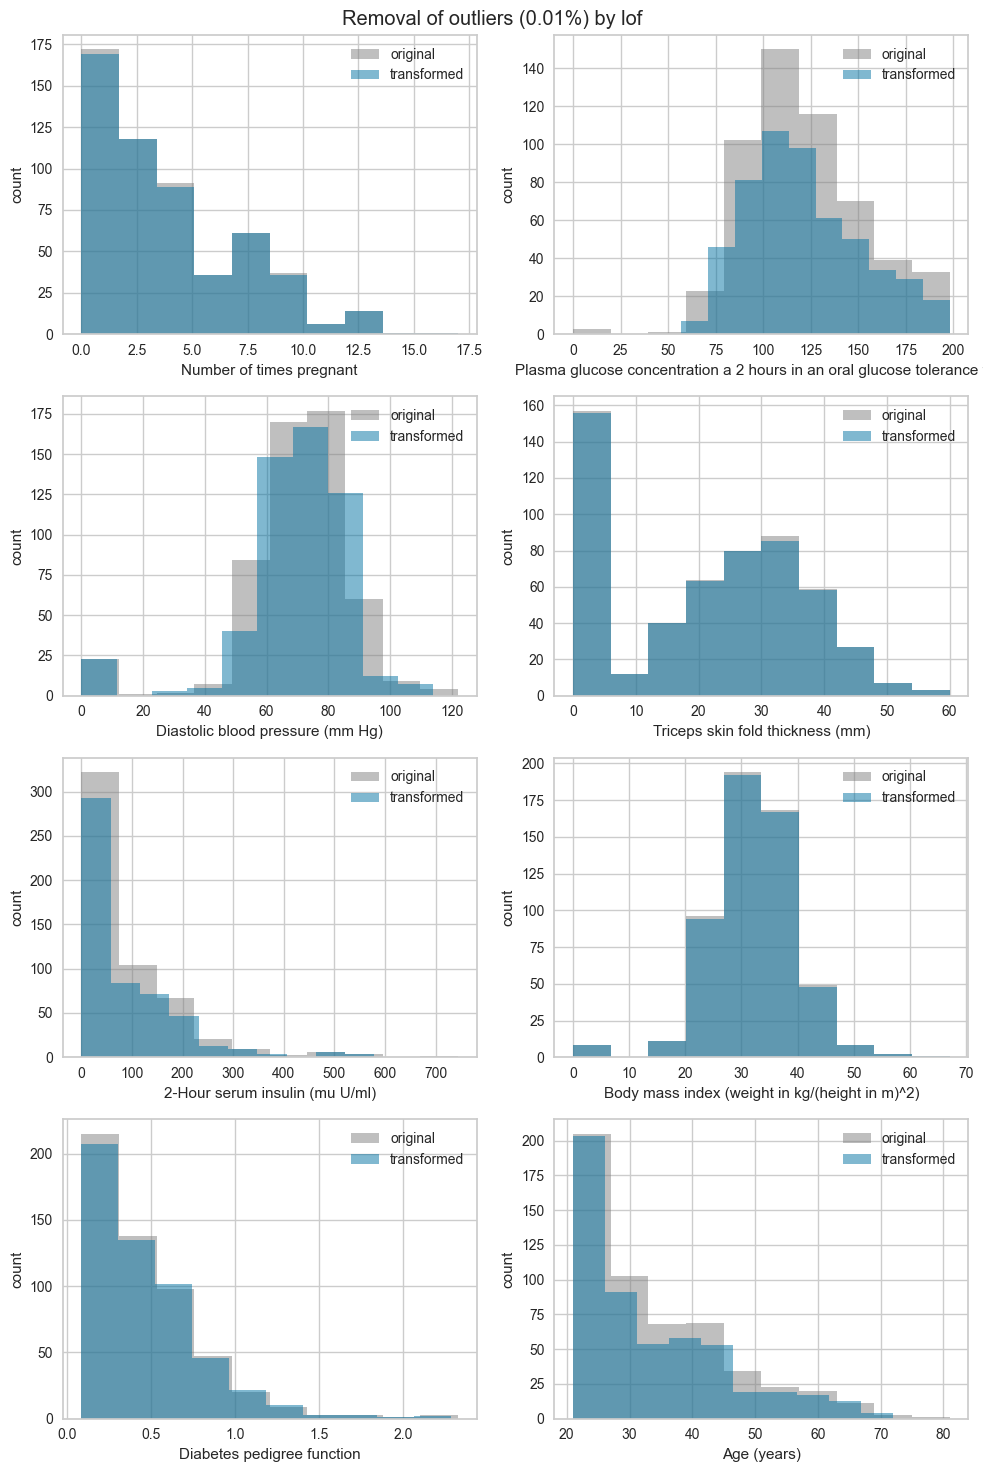

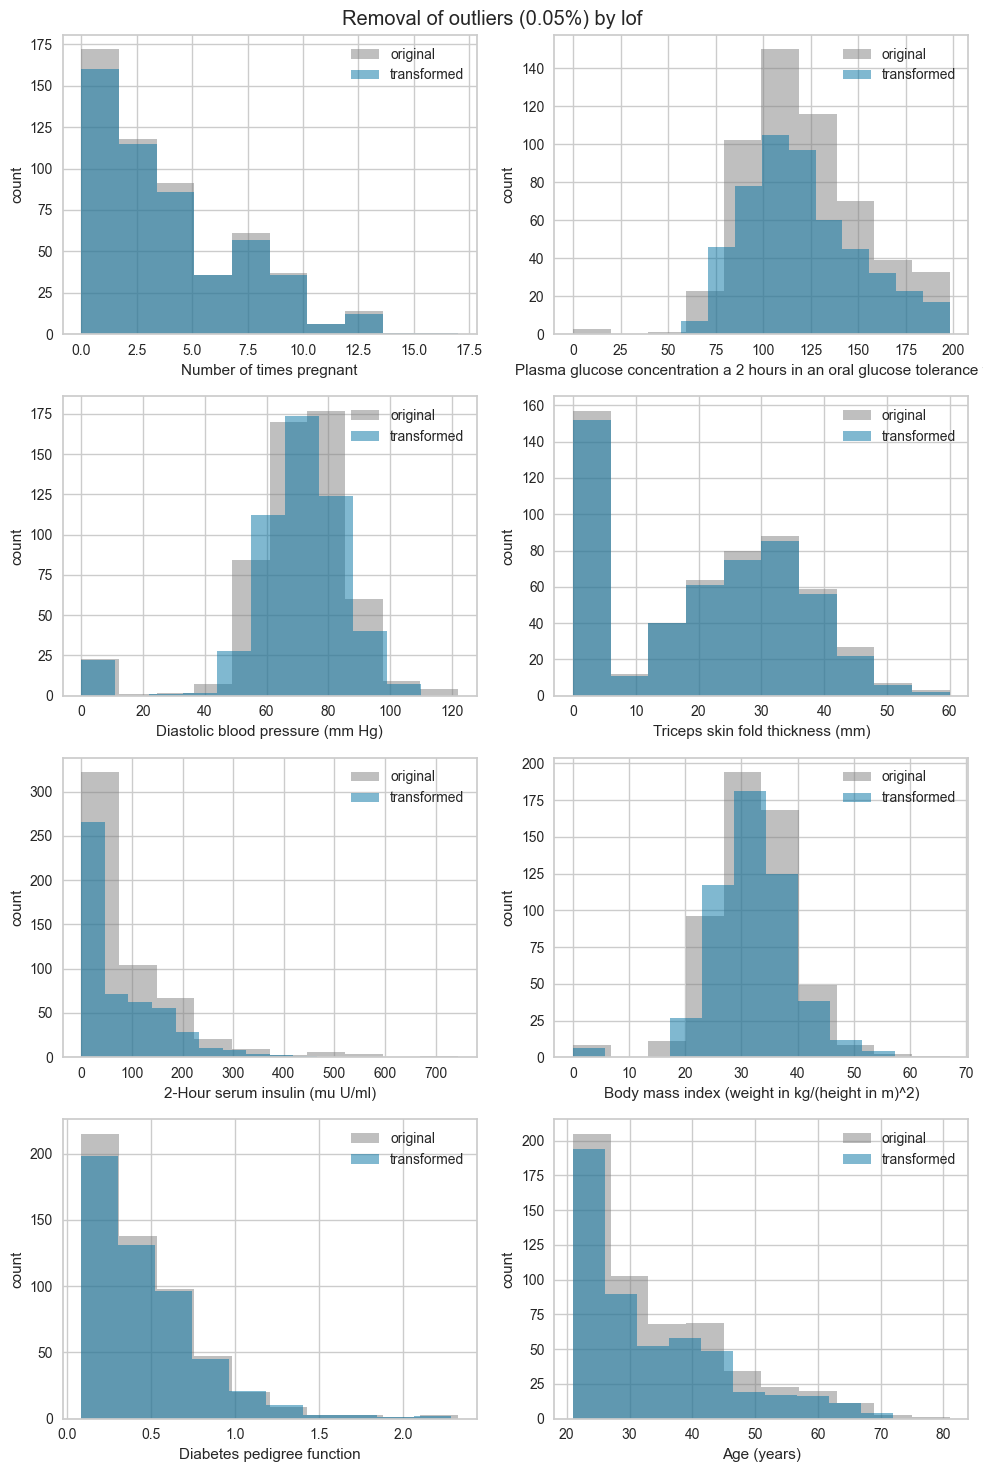

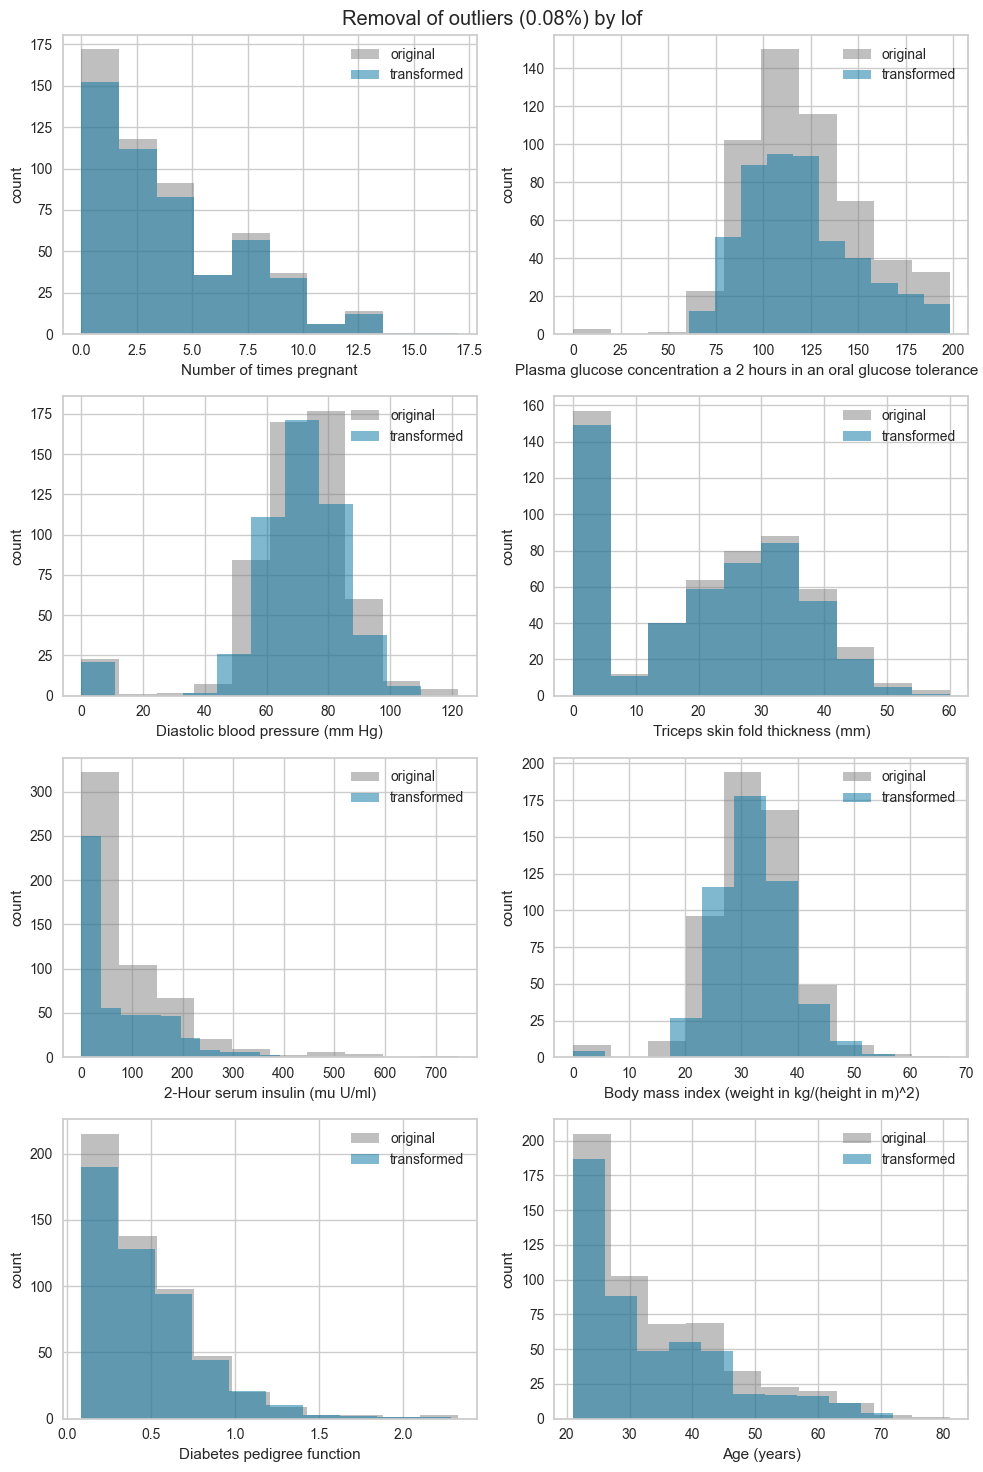

In [154]:
#target = 'Class variable'
#analyze_rm_outliers(data, target, pycaret_config)

,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(689, 9)"
4,Transformed data shape,"(290, 9)"
5,Transformed train set shape,"(202, 9)"
6,Transformed test set shape,"(88, 9)"
7,Numeric features,8
8,Rows with missing values,57.9%
9,Preprocess,True


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(689, 9)"
4,Transformed data shape,"(689, 9)"
5,Transformed train set shape,"(482, 9)"
6,Transformed test set shape,"(207, 9)"
7,Numeric features,8
8,Rows with missing values,57.9%
9,Preprocess,True


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(689, 9)"
4,Transformed data shape,"(689, 9)"
5,Transformed train set shape,"(482, 9)"
6,Transformed test set shape,"(207, 9)"
7,Numeric features,8
8,Rows with missing values,57.9%
9,Preprocess,True


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(689, 9)"
4,Transformed data shape,"(689, 9)"
5,Transformed train set shape,"(482, 9)"
6,Transformed test set shape,"(207, 9)"
7,Numeric features,8
8,Rows with missing values,57.9%
9,Preprocess,True


,Description,Value
0,Session id,42
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(689, 9)"
4,Transformed data shape,"(689, 9)"
5,Transformed train set shape,"(482, 9)"
6,Transformed test set shape,"(207, 9)"
7,Numeric features,8
8,Rows with missing values,57.9%
9,Preprocess,True


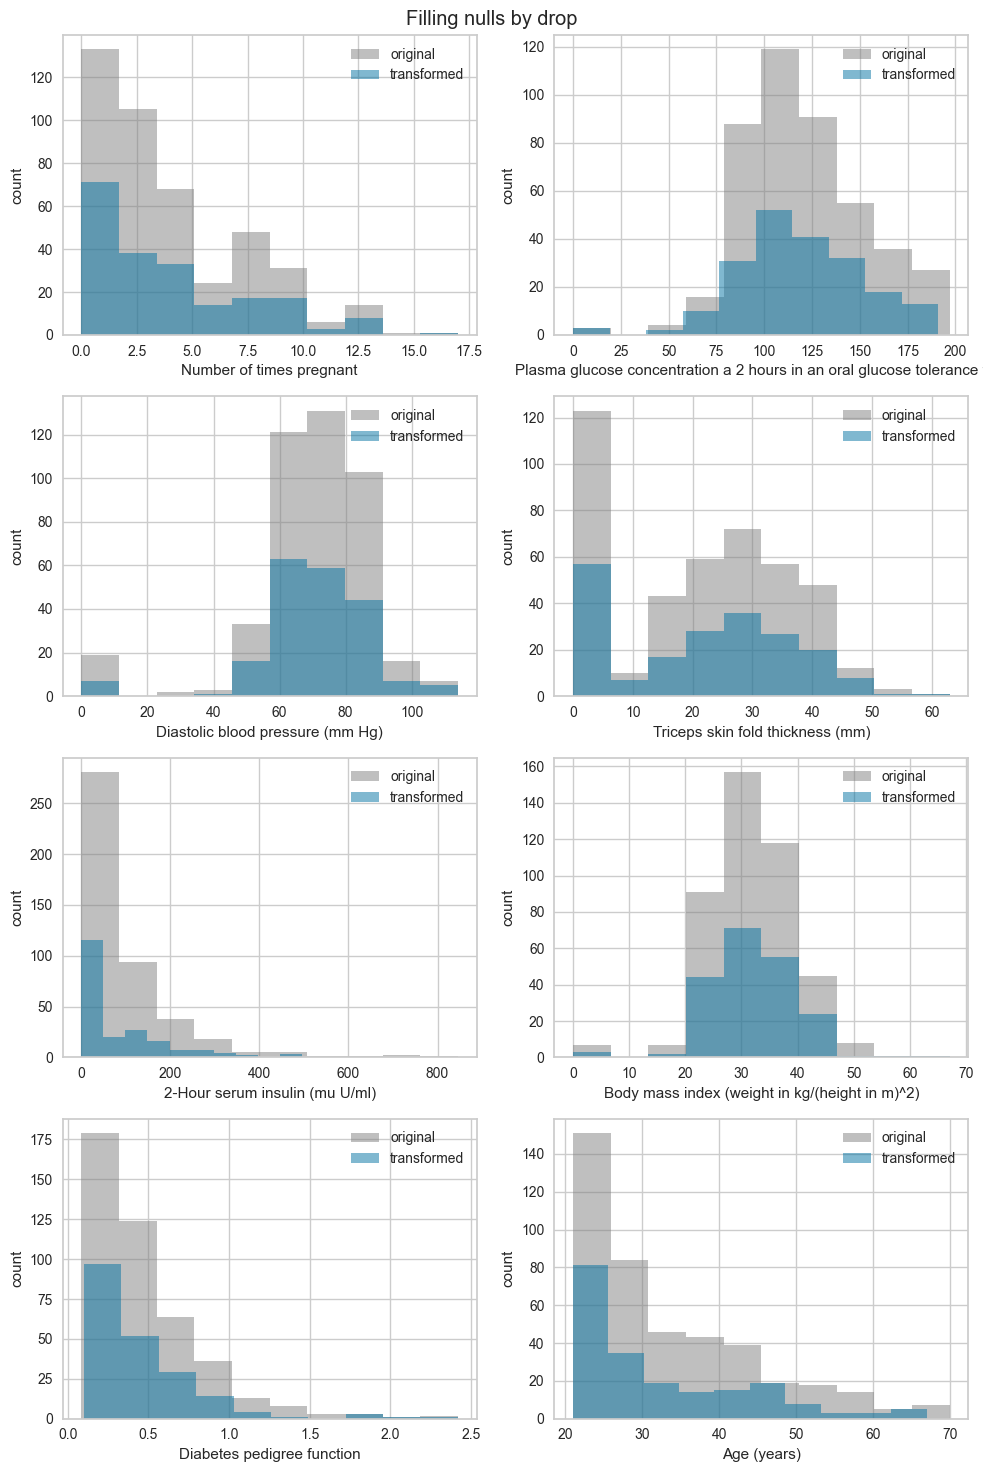

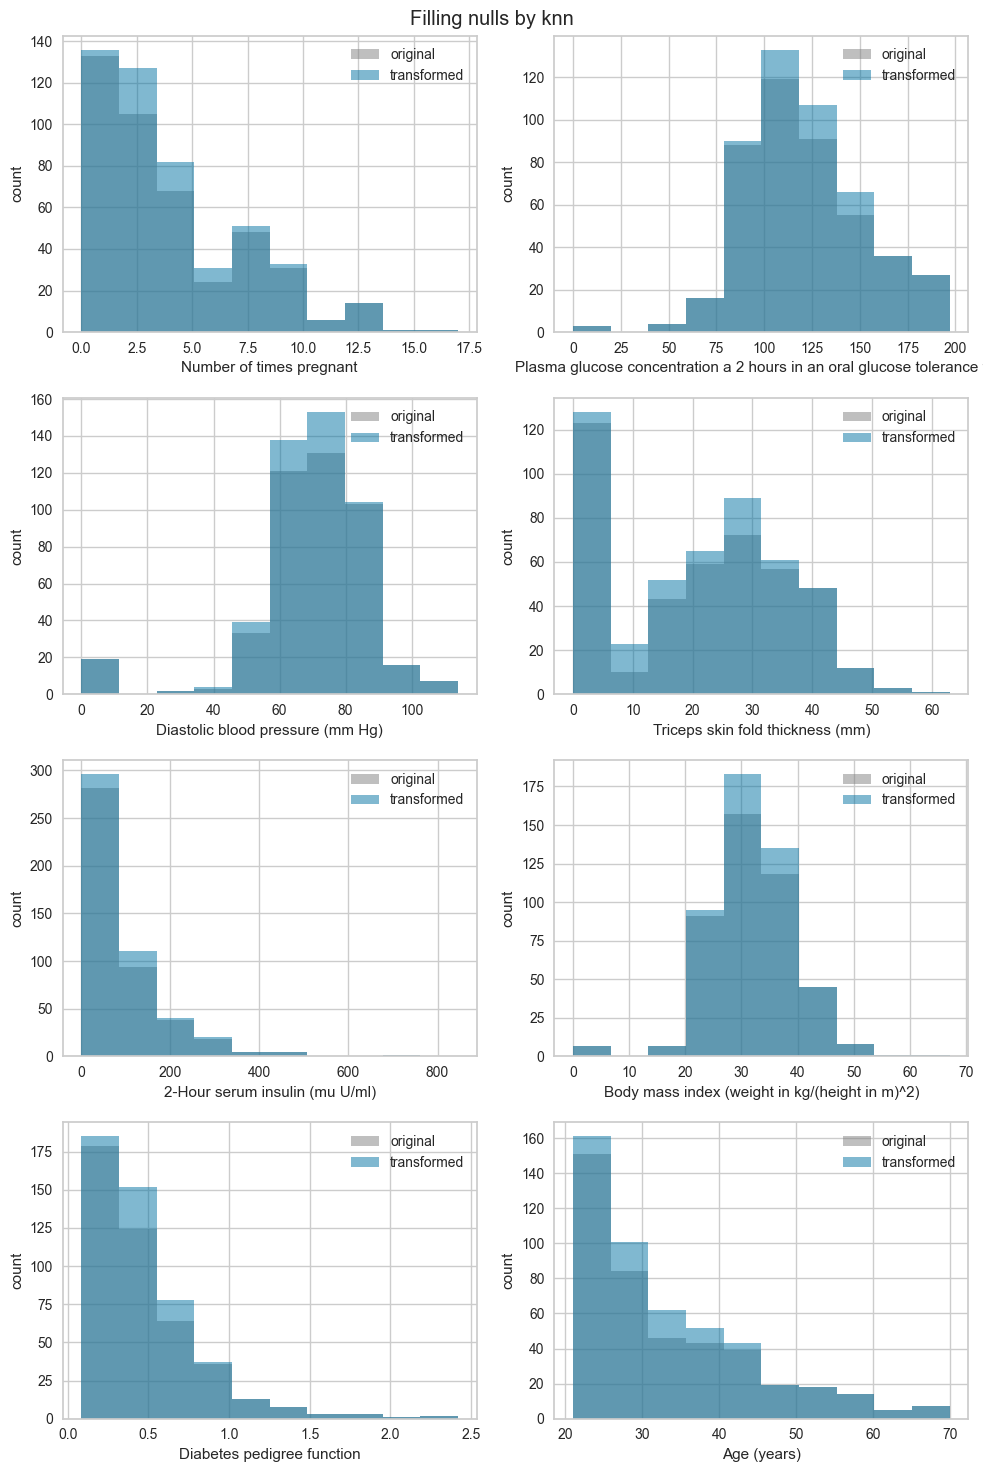

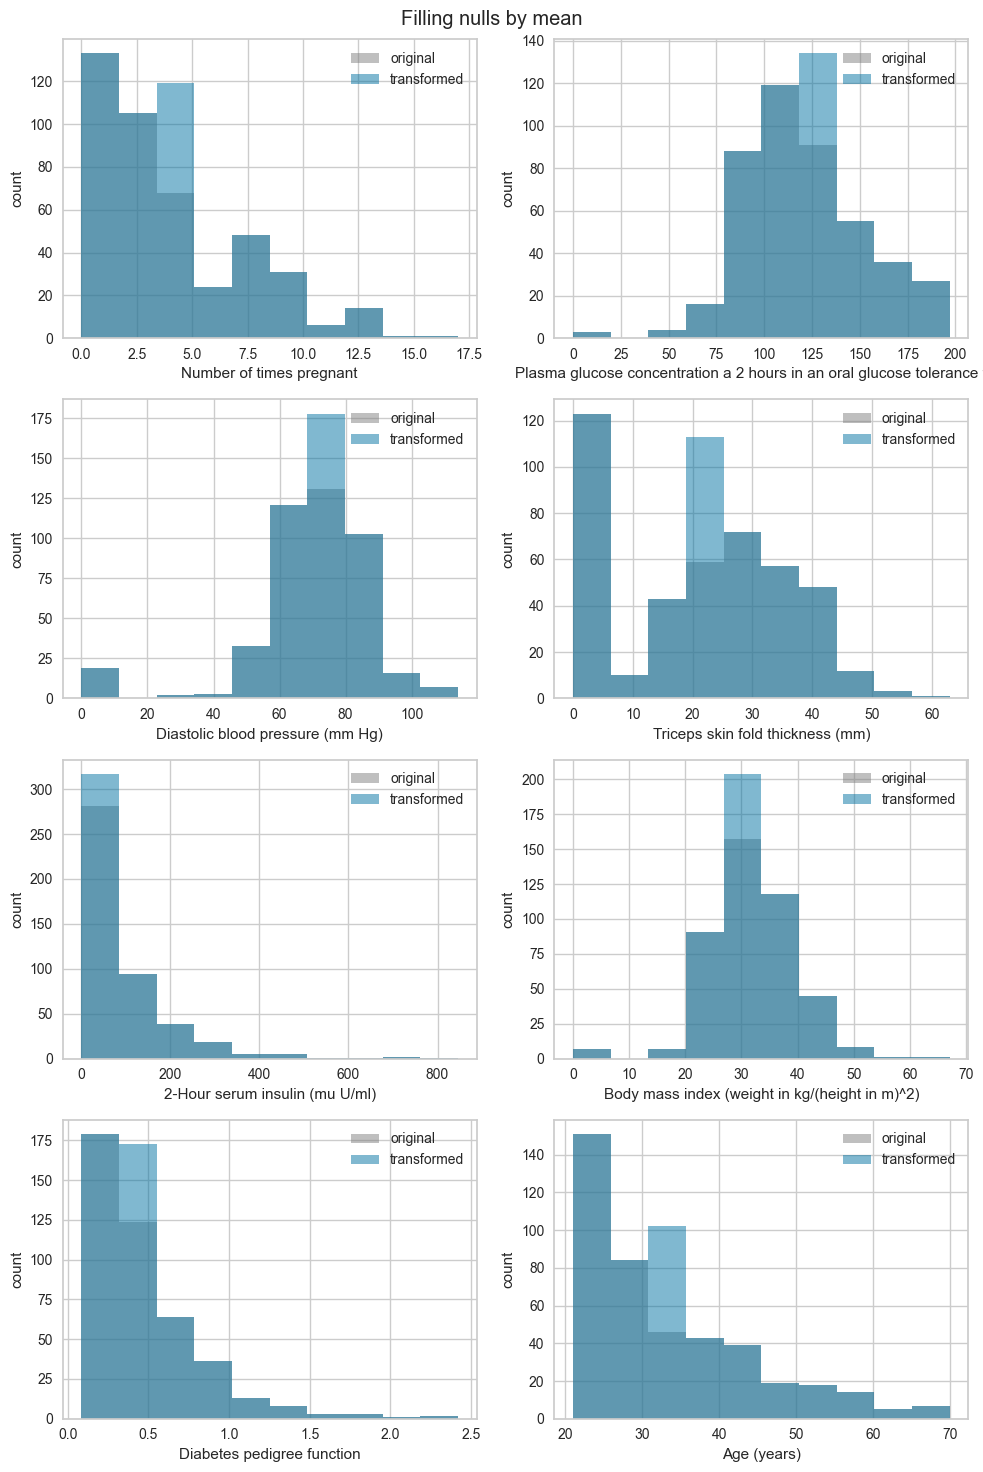

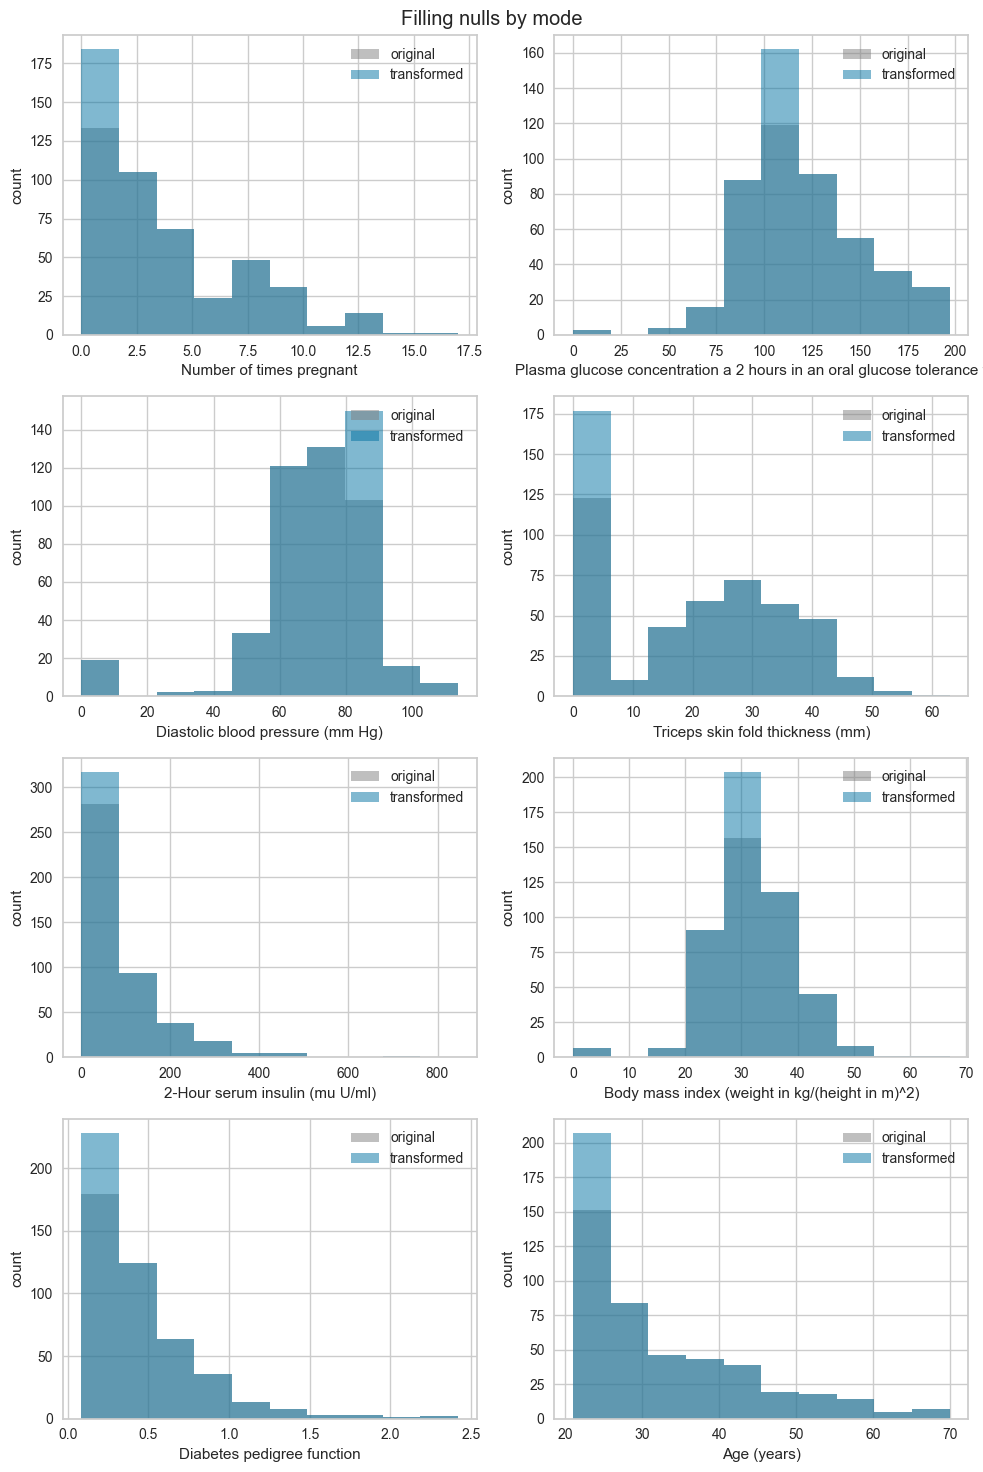

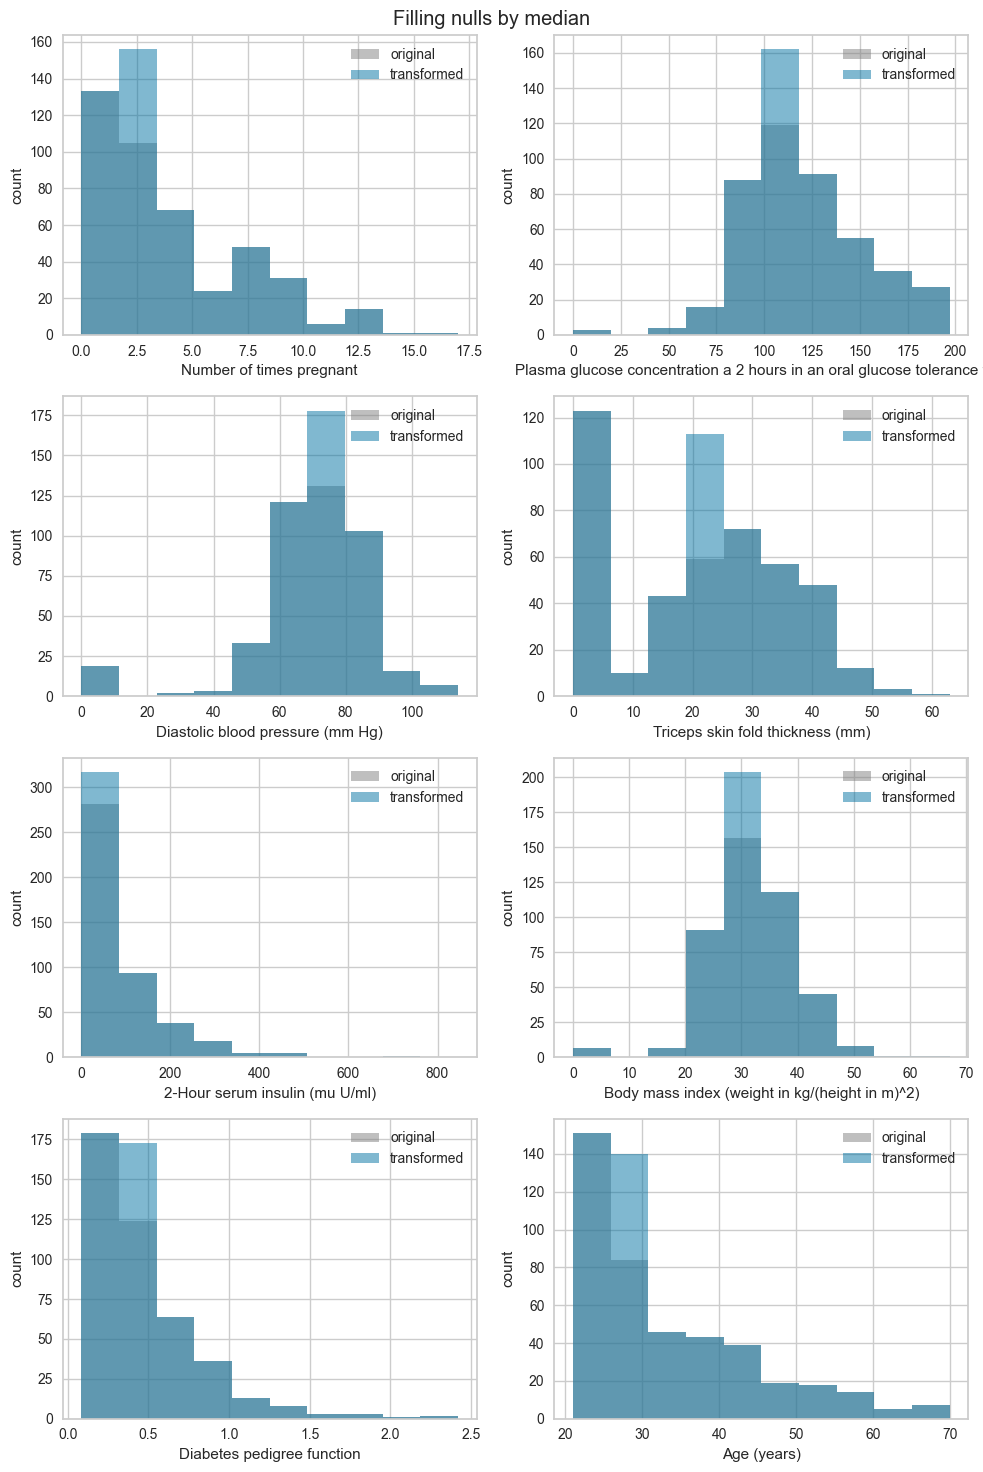

In [226]:
#target = 'Class variable'
#analyze_num_input(data, target, pycaret_config)

### Explainer Dashboards

In [ ]:
from explainerdashboard import ClassifierExplainer
from explainerdashboard import ExplainerDashboard
import pickle

In [15]:
test = setup(data.set_index('Id'), target = 'Purchase', **pycaret_config)
test_model = test.create_model('xgboost')
#explainer = ClassifierExplainer(test_model, test.get_config('X_test_transformed'), test.get_config('y_test_transformed'))
#test_db = ExplainerDashboard(explainer)

,Description,Value
0,Session id,42
1,Target,Purchase
2,Target type,Binary
3,Target mapping,"CH: 0, MM: 1"
4,Original data shape,"(1070, 18)"
5,Transformed data shape,"(1070, 18)"
6,Transformed train set shape,"(749, 18)"
7,Transformed test set shape,"(321, 18)"
8,Ordinal features,1
9,Numeric features,16


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7733,0.8726,0.7241,0.7000,0.7119,0.5251,0.5253
1,0.7333,0.7890,0.8276,0.6154,0.7059,0.4715,0.4888
2,0.7733,0.8628,0.7241,0.7000,0.7119,0.5251,0.5253
3,0.7333,0.8456,0.6552,0.6552,0.6552,0.4378,0.4378
4,0.8800,0.9145,0.7586,0.9167,0.8302,0.7387,0.7466
5,0.8533,0.9265,0.7241,0.8750,0.7925,0.6806,0.6879
6,0.8533,0.9108,0.8276,0.8000,0.8136,0.6927,0.6930
7,0.8533,0.8904,0.8000,0.8276,0.8136,0.6927,0.6930
8,0.6800,0.7259,0.5667,0.6071,0.5862,0.3258,0.3264


In [52]:
def log_explainerdb(pycaret_setup, model, target_class, index, artifact_path):
    
    # Check if dir exists, otherwise create directory
    dashboard_path = artifact_path + "explainable_ai/dashboard/"
    if not os.path.exists(dashboard_path):
        os.makedirs(dashboard_path)
    
    # Init explainer and create dashboard
    explainer = ClassifierExplainer(model, pycaret_setup.get_config('X_test_transformed'), pycaret_setup.get_config('y_test_transformed'))
    dashboard = ExplainerDashboard(explainer)
    
    # Save dataset
    data.set_index(index).to_csv(dashboard_path + 'data.csv')

    # Save dashboard
    explainer.dump(dashboard_path + "explainer.joblib")
    dashboard.to_yaml(dashboard_path + "dashboard.yaml", explainerfile=dashboard_path + "explainer.joblib")

    # Save model
    pickle.dump(model, open(dashboard_path + "model.pkl", "wb"))

    # Save explainer
    explainer.to_yaml("explainer.yaml",
                        explainerfile="explainer.joblib",
                        modelfile="model.pkl",
                        datafile="data.csv",
                        target_col=target_class,
                        index_col="Name",
                        dashboard_yaml="dashboard.yaml")

In [53]:
#!explainerdashboard build explainer.yaml
#!explainerdashboard run dashboard.yaml

### Responsible AI

In [16]:
from raiwidgets import ResponsibleAIDashboard
from responsibleai import RAIInsights

In [17]:
X_train = get_config(variable='X_train').reset_index().drop(['Id'], axis=1)
y_train = get_config(variable='y_train').reset_index().drop(['Id'], axis=1)['Purchase']
X_test = get_config(variable='X_test').reset_index().drop(['Id'], axis=1)
y_test = get_config(variable='y_test').reset_index().drop(['Id'], axis=1)['Purchase']
df_train = X_train.copy()
df_train['Purchase'] = y_train
df_test = X_test.copy()
df_test['Purchase'] = y_test

In [18]:
rai_insights = RAIInsights(test_model
                           , df_train
                           , df_test
                           , 'Purchase'
                           , 'classification'
                           , categorical_features = ['Store7'])

# Interpretability
rai_insights.explainer.add()
# Error Analysis
rai_insights.error_analysis.add()
# Counterfactuals: accepts total number of counterfactuals to generate, the label that they should have, and a list of 
# strings of categorical feature names
rai_insights.counterfactual.add(total_CFs=10, desired_class='opposite')
# Causal analysis
#rai_insights.causal.add(treatment_features=[‘Credit_History_1.0’, ‘Married_Yes’])

rai_insights.compute()

UserConfigValidationException: The passed model cannot be used for getting predictions via predict

In [ ]:
ResponsibleAIDashboard(rai_insights)